In [3]:
import torch 
from torch import nn, optim,utils
from torchinfo import summary
import numpy as np
import tqdm

class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_model = None

    def early_stop(self,model, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model =model.copy()
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader,test_loader,patience=3,epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-06)
    early_stopping = EarlyStopping(patience=patience)
    for epoch in range(epochs):
        model.train()
        train_epoch_loss=[]
        for idx, (x, y) in tqdm.tqdm(enumerate(train_loader)):
            outputs = model(x)
            optimizer.zero_grad()
            loss = criterion(y, outputs)
            loss.backward()
            train_epoch_loss.append(loss.item())
            optimizer.step()
        train_loss = np.average(train_epoch_loss)
        valid_epoch_loss = []
        model.eval()
        for idx, (data_x, data_y) in enumerate(test_loader):
            outputs = model(data_x)
            loss = criterion(data_y, outputs)
            valid_epoch_loss.append(loss.item())
        valid_loss = np.average(valid_epoch_loss)
        print("epoch={}/{} of train, train loss={}, valid loss={}".format(epoch + 1, epochs,train_loss, valid_loss))
        if early_stopping.early_stop(model,valid_loss):             
            break
    return early_stopping.best_model

def set_seed(random_seed=41):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

class NPDataset(utils.data.Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X,dtype=torch.float)
        self.y = torch.tensor(y,dtype=torch.float).reshape((-1, 1))

    def __getitem__(self, item):
        return self.X[item], self.y[item]

    def __len__(self):
        return len(self.y)
  

class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda,self).__init__()
        self.func = func
 
    def forward(self, x):
        return self.func(x)
    
    
class CNN(nn.Module):

    def __init__(self, seq_len=44):
        super(CNN, self).__init__()
        self.seq_len=seq_len
#         self.model=self.cnn_lstm_model()
        self.model=self.cnn1_model()
#         self.model=self.cnn_model()
#         self.model.apply(self.init_weights)
    
        
    
    def cnn_model(self,):
        model = nn.Sequential()
        model.append(nn.Conv1d(in_channels=4, out_channels=100, kernel_size=(5,), padding=2))
        model.add_module("conv0",nn.ReLU())
        model.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(5,), padding=2))
        model.add_module("conv1",nn.ReLU())
        model.append(nn.Dropout(p=0.3))
        model.append(nn.Conv1d(in_channels=100, out_channels=200, kernel_size=(5,), padding=2))
        model.add_module("conv2",nn.ReLU())
        model.append(nn.BatchNorm1d(200))
        model.append(nn.Dropout(p=0.3))
        model.append(nn.Flatten())
        model.add_module("linear",nn.Linear(200*seq_len,100))
        model.append(nn.ReLU())
        model.append(nn.Dropout(p=0.3))
        model.append(nn.Linear(100,1))
        return model
    
    def cnn1_model(self,):
        model = nn.Sequential()
        model.append(nn.Conv1d(in_channels=4, out_channels=100, kernel_size=(5,), padding=2))
        model.add_module("conv0",nn.ReLU())
        model.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(5,), padding=2))
        model.add_module("conv1",nn.ReLU())
        model.append(nn.MaxPool1d(2, stride=2))
        model.append(nn.Dropout(p=0.3))
        model.append(nn.Conv1d(in_channels=100, out_channels=200, kernel_size=(5,), padding=2))
        model.add_module("conv2",nn.ReLU())
        model.append(nn.MaxPool1d(2, stride=2))
        model.append(nn.Conv1d(in_channels=200, out_channels=200, kernel_size=(5,), padding=2))
        model.append(nn.BatchNorm1d(200))
        model.add_module("conv3",nn.ReLU())
        model.append(nn.Dropout(p=0.3))
        model.append(nn.Flatten())
        model.add_module("linear",nn.Linear(200*(seq_len//4),100))
        model.append(nn.ReLU())
        model.append(nn.Dropout(p=0.3))
        model.append(nn.Linear(100,1))
        return model
    
    def cnn_lstm_model(self,):
        model = nn.Sequential()
        model.append(nn.Conv1d(in_channels=4, out_channels=100, kernel_size=(5,), padding=2))
        model.append(nn.ReLU())
        model.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(5,), padding=2))
        model.append(nn.ReLU())
        model.append(nn.Dropout(p=0.15))
        model.append(nn.Conv1d(in_channels=100, out_channels=200, kernel_size=(5,), padding=2))
        model.append(nn.ReLU())
        model.append(nn.BatchNorm1d(200))
        model.append(nn.Dropout(p=0.15))
        model.append(Lambda(lambda x:torch.permute(x,(0,2,1))))
        model.append(nn.LSTM(200,200,batch_first=True,bidirectional=True))
        model.append(Lambda(lambda x:x[0][:,-1,:]))
        model.append(nn.Linear(200*2,100))
        model.append(nn.ReLU())
        model.append(nn.Dropout(p=0.15))
        model.add_module("linear",nn.Linear(100,1))
        return model
    
    def cnn_lstm1_model(self,):
        model = nn.Sequential()
        model.append(nn.Conv1d(in_channels=4, out_channels=100, kernel_size=(5,), padding=2))
        model.append(nn.ReLU())
        model.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(5,), padding=2))
        model.append(nn.ReLU())
        model.append(nn.MaxPool1d(2, stride=2))
        model.append(nn.Dropout(p=0.3))
        model.append(nn.Conv1d(in_channels=100, out_channels=200, kernel_size=(5,), padding=2))
        model.append(nn.ReLU())
        model.append(nn.MaxPool1d(2, stride=2))
        model.append(nn.Conv1d(in_channels=200, out_channels=200, kernel_size=(5,), padding=2))
        model.append(nn.BatchNorm1d(200))
        model.append(nn.ReLU())
        model.append(nn.Dropout(p=0.3))
        model.append(Lambda(lambda x:torch.permute(x,(0,2,1))))
        model.append(nn.LSTM(200,100,batch_first=True))
        model.append(Lambda(lambda x:torch.flatten(x[0],1,2)))
        model.append(nn.Linear(100*(seq_len//4),100))
#         model.append(nn.LSTM(200,100,batch_first=True,bidirectional=True))
#         model.append(Lambda(lambda x:torch.flatten(x[0],1,2)))
#         model.append(nn.Linear(100*(seq_len//4)*2,100))
        model.append(nn.ReLU())
        model.append(nn.Dropout(p=0.3))
        model.add_module("linear",nn.Linear(100,1))
        return model
    
    def init_weights(self,m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        elif isinstance(m, nn.Conv1d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        elif isinstance(m, nn.LSTM):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
            
    def forward(self, x):
        x= torch.permute(x,(0,2,1))
        return self.model(x)
    
    def copy(self):
        import copy
        model = CNN(self.seq_len)
        model.model = copy.deepcopy(self.model)
        return model

class WrapModel(object):
    def __init__(self, model):
        self.model=model
        
    def extract_layer_output(self, x,layer_name):
        buffer=[]
        def regist_hook():
            def layer_hook(module, inp, out):
                buffer.append(out.data.detach().numpy())
            getattr(self.model.model, layer_name).register_forward_hook(layer_hook)
        regist_hook()
        self.model.eval()
        y = self.model(x)
        layer_out = np.concatenate(buffer)
        if len(layer_out.shape)==3:
            layer_out=np.max(layer_out, axis=1)
        return layer_out, y.detach().numpy()
        
fdata="/Users/john/data"
seq_len,fn=26,f"{fdata}/models/sev.pt"
model = torch.load(fn)
model =CNN(seq_len=seq_len)
print(summary(model, input_size=(16, seq_len, 4)))
data= torch.rand((25, seq_len, 4))
print(model(data).shape)
# torch.save(model,f"{fdata}/models/sev.pt")


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [16, 1]                   --
├─Sequential: 1-1                        [16, 1]                   --
│    └─Conv1d: 2-1                       [16, 100, 26]             2,100
│    └─ReLU: 2-2                         [16, 100, 26]             --
│    └─Conv1d: 2-3                       [16, 100, 26]             50,100
│    └─ReLU: 2-4                         [16, 100, 26]             --
│    └─MaxPool1d: 2-5                    [16, 100, 13]             --
│    └─Dropout: 2-6                      [16, 100, 13]             --
│    └─Conv1d: 2-7                       [16, 200, 13]             100,200
│    └─ReLU: 2-8                         [16, 200, 13]             --
│    └─MaxPool1d: 2-9                    [16, 200, 6]              --
│    └─Conv1d: 2-10                      [16, 200, 6]              200,200
│    └─BatchNorm1d: 2-11                 [16, 200, 6]              4

In [4]:
import Levenshtein
import pandas as pd
import scipy.stats as stats
from sklearn import preprocessing
def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        lst = [nuc_d[x] for x in seq]
        if seq_len>len(seq):
            lst += [nuc_d['n']]*(seq_len-len(seq))
        a = np.array(lst)
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    # Make predictions
    model.eval()
    predictions = model(torch.tensor(test_seq,dtype=torch.float)).reshape(-1,1).detach().numpy()
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

# SEV
original_seq = 'atcccgggtgaggcatcccaccatcctcagtcacagagagacccaatctaccatcagcatcagccagtaaagattaagaaaaacttagggtgaaagaaatttcacctaacacggcgca'
# SFV
# original_seq = 'atggcggatgtgtgacatacacgacgccaaaagattttgttccagctcctgccacctccgctacgcgagagattaaccacccacg'
# VEE
# original_seq = 'atgggcggcgcatgagagaagcccagaccaattacctacccaaa'
original_seq=original_seq.upper()
name,seq_len,suff="INFL_0522",26,"" # 0.94,0.94,0.95
# name,seq_len,suff="VEE_0816",44,"_tol_seq" # 0.83,0.83,0.82
# name,seq_len,suff="SFV_0719",85,"" #0.77, 0.79,0.78
datadir=f"{fdata}/5UTR/{name}_"
# name,seq_len,suff = "pl3-1-2",118,""
# datadir=f"/Users/john/data/Promter/results/{name}/{name}_"
e_train = pd.read_csv(f"{datadir}train{suff}.csv")
e_test= pd.read_csv(f"{datadir}test{suff}.csv")
e_train['distance'] = e_train.seq.apply(lambda x: Levenshtein.distance(original_seq, x))
e_test['distance'] = e_test.seq.apply(lambda x: Levenshtein.distance(original_seq, x))
e_train["score"] = e_train['score_final']
e_test["score"] = e_test['score_final']
print(e_train.shape, e_test.shape)
label="score"
batch_size= 64
set_seed(41)
train_x = one_hot_encode(e_train,seq_len=seq_len)
test_x = one_hot_encode(e_test, seq_len=seq_len)
test_y = preprocessing.StandardScaler().fit_transform(e_test.loc[:,label].values.reshape(-1,1))
tran_y = preprocessing.StandardScaler().fit_transform(e_train.loc[:,label].values.reshape(-1,1))
dataset_train = NPDataset(train_x,tran_y)
dataset_test = NPDataset(test_x,test_y)
train_loader = utils.data.DataLoader(dataset_train, batch_size=batch_size,shuffle=True)
test_loader = utils.data.DataLoader(dataset_train, batch_size=batch_size)
model = CNN(seq_len)
model=train(model, train_loader, test_loader,patience=5)
# model = torch.load("/Users/john/data/models/sev_pl3_5.pt")
test_data(df=e_test, model=model, obs_col=label,test_seq=test_x)
r = r2(e_test['pred'],e_test["score"])
pr =  stats.pearsonr(e_test['pred'],e_test["score"] )
print('test flu r-squared = ', r, "pearsonR = ", pr[0])
torch.save(model,f"{fdata}/models/{name}.pt")

(5173, 11) (265, 11)


81it [00:05, 15.98it/s]


epoch=1/20 of train, train loss=0.505061697260833, valid loss=0.1103145076352873


81it [00:05, 15.65it/s]


epoch=2/20 of train, train loss=0.22144068032503128, valid loss=0.33906977577709857


81it [00:04, 17.34it/s]


epoch=3/20 of train, train loss=0.18231949044598472, valid loss=0.09185948839158188


81it [00:04, 16.37it/s]


epoch=4/20 of train, train loss=0.16116710476301335, valid loss=0.10529664342786059


81it [00:05, 14.48it/s]


epoch=5/20 of train, train loss=0.15786306652021997, valid loss=0.08723573910969275


81it [00:04, 16.66it/s]


epoch=6/20 of train, train loss=0.14380509903033575, valid loss=0.0763177600355796


81it [00:06, 12.58it/s]


epoch=7/20 of train, train loss=0.13562664877117417, valid loss=0.07321259034452615


81it [00:06, 11.90it/s]


epoch=8/20 of train, train loss=0.1288646352879795, valid loss=0.07983321733312843


81it [00:07, 10.98it/s]


epoch=9/20 of train, train loss=0.12949964900811514, valid loss=0.07215333090704164


81it [00:08,  9.87it/s]


epoch=10/20 of train, train loss=0.12757448594511292, valid loss=0.06932523911014016


81it [00:05, 14.28it/s]


epoch=11/20 of train, train loss=0.12831743677825103, valid loss=0.09163430448115607


81it [00:04, 17.82it/s]


epoch=12/20 of train, train loss=0.12139979004859924, valid loss=0.06082860966799436


81it [00:04, 18.28it/s]


epoch=13/20 of train, train loss=0.11742032880400434, valid loss=0.06680715212851394


81it [00:05, 14.84it/s]


epoch=14/20 of train, train loss=0.11774656682470698, valid loss=0.12991040669105672


81it [00:04, 18.59it/s]


epoch=15/20 of train, train loss=0.11549985224818006, valid loss=0.06294896140878584


81it [00:04, 18.29it/s]


epoch=16/20 of train, train loss=0.10580404907648946, valid loss=0.05613791717239368


81it [00:04, 16.61it/s]


epoch=17/20 of train, train loss=0.10412510930572028, valid loss=0.0650451883305738


81it [00:04, 16.99it/s]


epoch=18/20 of train, train loss=0.10304634176470616, valid loss=0.07413372429616658


81it [00:04, 17.50it/s]


epoch=19/20 of train, train loss=0.1083886856098234, valid loss=0.0895922209745572


81it [00:04, 18.57it/s]


epoch=20/20 of train, train loss=0.10848308368413537, valid loss=0.06959505287217504
test flu r-squared =  0.9457046601217238 pearsonR =  0.9724734752792613


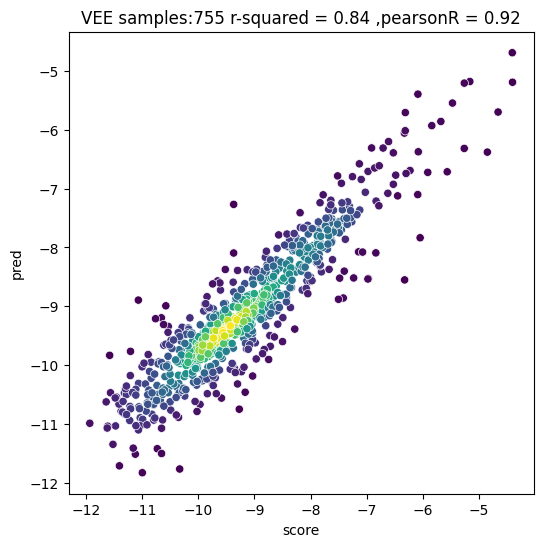

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sdf=e_test
num=len(sdf)
name = name.split("_")[0] if "_"in name else "SEV"
values = np.vstack([sdf["score"], sdf['pred']])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(6, 6))
r = r2(sdf["score"],sdf["pred"])
pr =  stats.pearsonr(sdf["score"],sdf["pred"])
plt.title(f"{name} samples:{num} r-squared = {r:.2f} ,pearsonR = {pr[0]:.2f}")
splot=sns.scatterplot(
    data=sdf,
    x="score",
    y="pred",
    c=kernel,
    cmap="viridis",
    ax=ax,
)

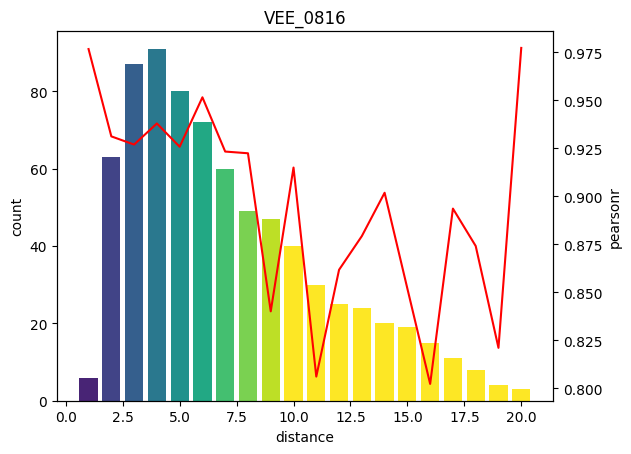

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
original_sev = 'atcccgggtgaggcatcccaccatcctcagtcacagagagacccaatctaccatcagcatcagccagtaaagattaagaaaaacttagggtgaaagaaatttcacctaacacggcgca'.upper()
original_sfv = 'atggcggatgtgtgacatacacgacgccaaaagattttgttccagctcctgccacctccgctacgcgagagattaaccacccacg'.upper()
original_vee = 'atgggcggcgcatgagagaagcccagaccaattacctacccaaa'.upper()
original_infl = 'AGCAAAAGCAGGGTGACAAAAACATA'
original_seq=original_vee
pdf = e_test
pdf['distance'] = pdf.seq.apply(lambda x: Levenshtein.distance(original_seq, x))
ds, ps = [],[]
for dist,gdf in pdf.groupby("distance"):
    if len(gdf)>2:
        pr =  stats.pearsonr(gdf["score"],gdf["pred"])
        ds.append(dist)
        ps.append(pr[0])
prdf = pd.DataFrame({"distance":ds,"pearsonr":ps})
cntdf=pdf.groupby(["distance"])["seq"].count().reset_index(name='count')
cdf = prdf.merge(cntdf)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel("distance")
ax1.set_ylabel("count")
ax1.bar('distance','count',data=cdf,color=plt.cm.viridis(cdf["distance"].values/10))
ax2.plot('distance','pearsonr',data=cdf,color="r")
ax2.set_ylabel("pearsonr")
plt.title(f"{name}")
plt.show()

In [3]:
import torch
from sklearn.manifold import TSNE
model = torch.load("/Users/john/data/models/sev_pl3_5.pt")
rdf,input_x = e_test[:50],test_x[:50]
model=WrapModel(model)
rdf["pred"]=model(torch.Tensor(input_x)).detach().numpy()
data = model.buffer[0]
tsne = TSNE(n_components=2, random_state=0)
result = tsne.fit_transform(data)
rdf[["tsne_d1","tsne_d2"]]=result

/var/folders/g3/9kgyg0z54nv7fpxy0pgwx0y80000gn/T/ipykernel_78962/4101047520.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf["pred"]=model(torch.Tensor(input_x)).detach().numpy()
/Users/john/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/var/folders/g3/9kgyg0z54nv7fpxy0

In [ ]:
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
pdf = rdf
# plot
mpl.rcParams['figure.dpi'] = 120
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
# Creating plot
sctt=ax.scatter3D(pdf["tsne_d1"], pdf["tsne_d2"],pdf["pred"], c=pdf["pred"], cmap='viridis')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()